# Crime Fighters CS252A Project
# Names: Anand Mahadevan, Richard Jeong, Dylan Riffel

- Data was obtained from https://data.police.uk/data/
- The name at the start of each cell indicates who worked on that particular cell (how work was divided)

In [1]:
# IMPORTS
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import geopandas as gpd
import matplotlib.patches as mpatches
from geopy.geocoders import Nominatim
import time
from shapely.geometry import Point
import geodatasets as gds
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
print("pass")

pass


In [2]:
# Anand

# path to data folder
data_folder = "data/UK_Police_Data"

# dictionaries for each dataset type
outcomes_data = []
stop_and_search_data = []
street_data = []

# load data
for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)

            # assign to proper dict
            if 'outcomes' in file:
                outcomes_data.append(pd.read_csv(file_path))
            elif 'stop-and-search' in file:
                stop_and_search_data.append(pd.read_csv(file_path))
            elif 'street' in file:
                street_data.append(pd.read_csv(file_path))

# dict -> dataframe
outcomes_df = pd.concat(outcomes_data, ignore_index=True)
stop_and_search_df = pd.concat(stop_and_search_data, ignore_index=True)
street_df = pd.concat(street_data, ignore_index=True)

# dataframe info
print(outcomes_df.info())
print(stop_and_search_df.info())
print(street_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9108482 entries, 0 to 9108481
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Crime ID      object 
 1   Month         object 
 2   Reported by   object 
 3   Falls within  object 
 4   Longitude     float64
 5   Latitude      float64
 6   Location      object 
 7   LSOA code     object 
 8   LSOA name     object 
 9   Outcome type  object 
dtypes: float64(2), object(8)
memory usage: 694.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811563 entries, 0 to 811562
Data columns (total 15 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Type                                      811563 non-null  object 
 1   Date                                      811563 non-null  object 
 2   Part of a policing operation              466591 non-null  object 
 3   Policing operation          

In [3]:
# Anand

# missing values
print("Missing values in outcomes data:")
print(outcomes_df.isnull().sum())
print("\nMissing values in stop and search data:")
print(stop_and_search_df.isnull().sum())
print("\nMissing values in street data:")
print(street_df.isnull().sum())

# duplicates
print("\nDuplicate rows in outcomes data:", outcomes_df.duplicated().sum())
print("Duplicate rows in stop and search data:", stop_and_search_df.duplicated().sum())
print("Duplicate rows in street data:", street_df.duplicated().sum())

# drop duplicates
outcomes_df.drop_duplicates(inplace=True)
stop_and_search_df.drop_duplicates(inplace=True)
street_df.drop_duplicates(inplace=True)

Missing values in outcomes data:
Crime ID             0
Month                0
Reported by          0
Falls within         0
Longitude       157847
Latitude        157847
Location             0
LSOA code       157863
LSOA name       157863
Outcome type         0
dtype: int64

Missing values in stop and search data:
Type                                             0
Date                                             0
Part of a policing operation                344972
Policing operation                          811563
Latitude                                    100983
Longitude                                   100983
Gender                                       40450
Age range                                   110881
Self-defined ethnicity                       51314
Officer-defined ethnicity                    67268
Legislation                                  10439
Object of search                             61460
Outcome                                      19281
Outcome linked to ob

In [4]:
# Anand

# dataset exploration
def explore_data(df, name):
    print(f"\nExploration of {name} Dataset")
    print(df.describe(include='all'))
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nUnique Values:")
    for column in df.columns:
        print(f"{column}: {df[column].nunique()} unique values")
    print(f"\n\n--------------------------------------------------\n\n")

explore_data(street_df, 'Street')
explore_data(stop_and_search_df, 'Stop and Search')
explore_data(outcomes_df, 'Outcomes')


Exploration of Street Dataset
                                                 Crime ID    Month  \
count                                             8748634  9918155   
unique                                            8640498       21   
top     ae01a361148231feb7f5b48a803d9efb9c6d62299921eb...  2023-06   
freq                                                    7   511709   
mean                                                  NaN      NaN   
std                                                   NaN      NaN   
min                                                   NaN      NaN   
25%                                                   NaN      NaN   
50%                                                   NaN      NaN   
75%                                                   NaN      NaN   
max                                                   NaN      NaN   

                        Reported by                 Falls within  \
count                       9918155                      991

In [5]:
# Richard

# drop 'Context' column from street data as it’s completely missing
street_df.drop(columns=['Context'], inplace=True)

# drop 'Policing operation' column from stop_and_search data
stop_and_search_df.drop(columns=['Policing operation'], inplace=True)

# drop rows with missing coordinates because they have no details, useless rows
street_df.dropna(subset=['Longitude', 'Latitude'], inplace=True)
outcomes_df.dropna(subset=['Longitude', 'Latitude'], inplace=True)

# fill missing values in LSOA fields in street and outcomes with placeholder
street_df['LSOA code'].fillna('Unknown', inplace=True)
street_df['LSOA name'].fillna('Unknown', inplace=True)
outcomes_df['LSOA code'].fillna('Unknown', inplace=True)
outcomes_df['LSOA name'].fillna('Unknown', inplace=True)

# for stop and search data, fill empty categorical columns with 'Unknown'
stop_and_search_df['Part of a policing operation'].fillna('No', inplace=True)
stop_and_search_df['Gender'].fillna('Unknown', inplace=True)
stop_and_search_df['Age range'].fillna('Unknown', inplace=True)
stop_and_search_df['Self-defined ethnicity'].fillna('Unknown', inplace=True)
stop_and_search_df['Officer-defined ethnicity'].fillna('Unknown', inplace=True)
stop_and_search_df['Outcome'].fillna('Not Specified', inplace=True)

In [6]:
# Dylan

street_df = street_df[['Month', 'Latitude', 'Longitude', 'Crime type', 'LSOA code', 'LSOA name', 'Last outcome category']]
stop_and_search_df = stop_and_search_df[['Date', 'Latitude', 'Longitude', 'Age range', 'Object of search', 'Outcome']]
outcomes_df = outcomes_df[['Month', 'Latitude', 'Longitude', 'Outcome type']]

# Optimize data types
street_df['Latitude'] = street_df['Latitude'].astype('float32')
street_df['Longitude'] = street_df['Longitude'].astype('float32')
stop_and_search_df['Latitude'] = stop_and_search_df['Latitude'].astype('float32')
stop_and_search_df['Longitude'] = stop_and_search_df['Longitude'].astype('float32')
outcomes_df['Latitude'] = outcomes_df['Latitude'].astype('float32')
outcomes_df['Longitude'] = outcomes_df['Longitude'].astype('float32')

# Create 'Month' column in stop_and_search_df by extracting the year-month part from 'Date'
stop_and_search_df['Month'] = stop_and_search_df['Date'].str[:7]

# Combine Latitude and Longitude into a common identifier in all dataframes
street_df['ActualLocation'] = street_df['Latitude'].astype(str) + ", " + street_df['Longitude'].astype(str)
stop_and_search_df['ActualLocation'] = stop_and_search_df['Latitude'].astype(str) + ", " + stop_and_search_df['Longitude'].astype(str)
outcomes_df['ActualLocation'] = outcomes_df['Latitude'].astype(str) + ", " + outcomes_df['Longitude'].astype(str)

# Perform the merges
merged_data = street_df.merge(
    stop_and_search_df, on=['Month', 'ActualLocation'], how='outer', suffixes=('_street', '_search')
).merge(
    outcomes_df, on=['Month', 'ActualLocation'], how='outer', suffixes=('_search', '_outcomes')
)

# Drop unnecessary columns that overlap in content
columns_to_drop = [
    'Longitude_street', 'Latitude_street', 'Longitude_search', 'Latitude_search',
    'Longitude', 'Latitude', 'Location_search', 'Location_outcomes' , 'Date'
]
merged_data_cleaned = merged_data.drop(columns=[col for col in columns_to_drop if col in merged_data.columns])

# Display the first few rows of the cleaned merged data
print(merged_data_cleaned.head())

     Month                    Crime type  LSOA code             LSOA name  \
0  2023-01                  Public order  E01019077  Isles of Scilly 001A   
1  2023-01                         Drugs  E01019077  Isles of Scilly 001A   
2  2023-01  Violence and sexual offences  E01019077  Isles of Scilly 001A   
3  2023-01  Violence and sexual offences  E01019077  Isles of Scilly 001A   
4  2023-01                 Vehicle crime  E01019077  Isles of Scilly 001A   

         Last outcome category        ActualLocation Age range  \
0             Local resolution  49.913002, -6.307779       NaN   
1  Unable to prosecute suspect   49.91488, -6.315541       NaN   
2  Unable to prosecute suspect   49.91488, -6.315541       NaN   
3  Unable to prosecute suspect   49.91488, -6.315541       NaN   
4     Court result unavailable    49.924427, -6.3076       NaN   

  Object of search Outcome Outcome type  
0              NaN     NaN          NaN  
1              NaN     NaN          NaN  
2             

# VISUALIZATION

In [7]:
# Anand

sns.set(style="whitegrid")

# figure size
plt.rcParams['figure.figsize'] = [12, 6]

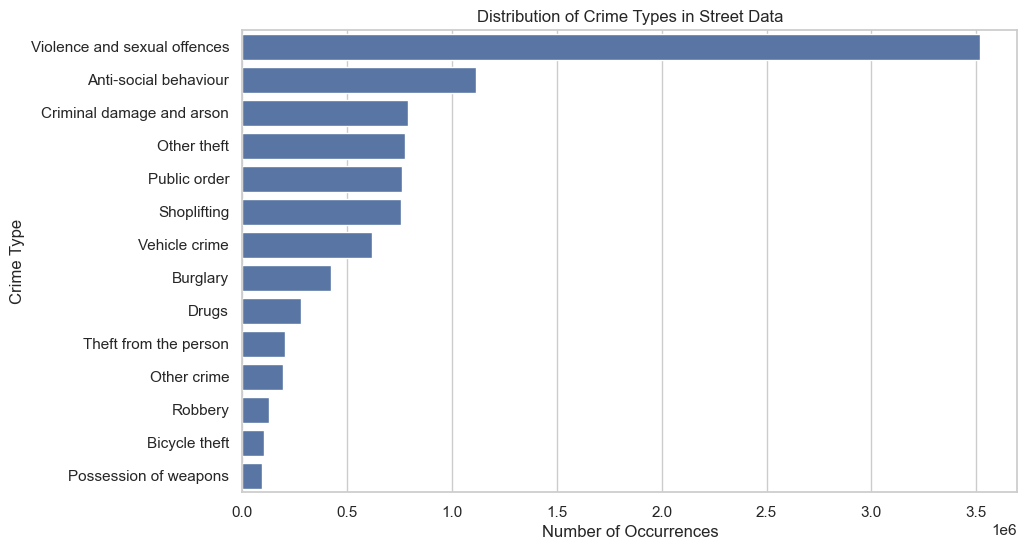

In [8]:
# Anand

# crime types distribution in street dataset

plt.figure(figsize=(10, 6))
sns.countplot(y='Crime type', data=street_df, order=street_df['Crime type'].value_counts().index)
plt.title('Distribution of Crime Types in Street Data')
plt.xlabel('Number of Occurrences')
plt.ylabel('Crime Type')
plt.show()

- A vast majority of the crime committed in the UK are violent and sexual in nature. The second most common offence is anti-social behavior, which means that these individuals disturbed public peace or committed vandalism.

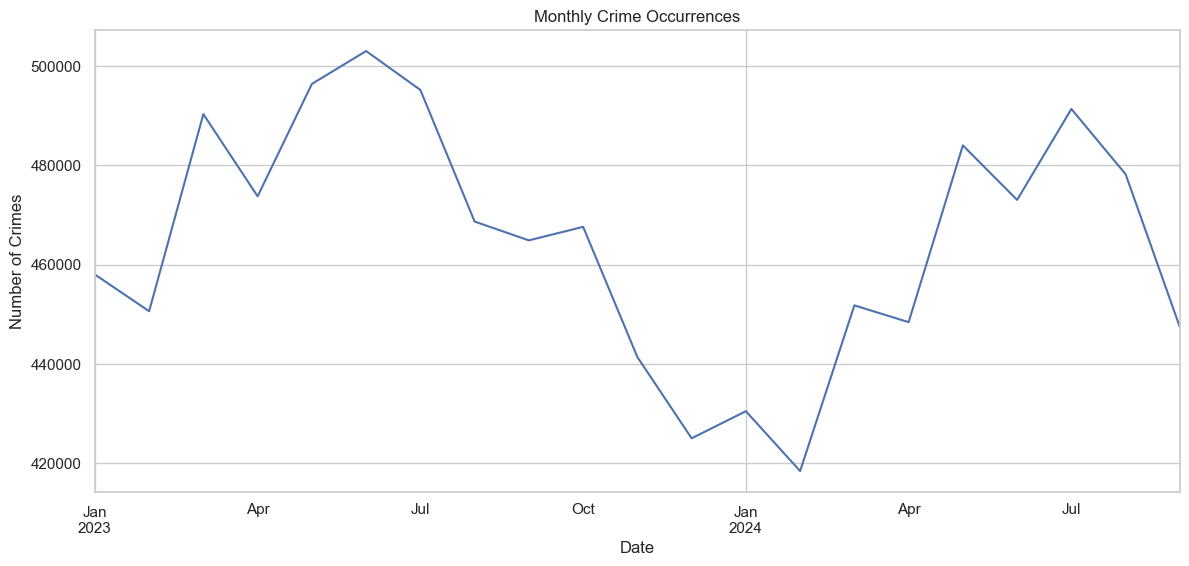

In [9]:
# Anand

# crime occurrences over time

street_df['Month'] = pd.to_datetime(street_df['Month'])
monthly_crime_counts = street_df['Month'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
monthly_crime_counts.plot()
plt.title('Monthly Crime Occurrences')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.show()

- There appears to be a cyclic spike in crime starting from the months of May and June, with crime occuring at a noticeably lower rate in the month of January.

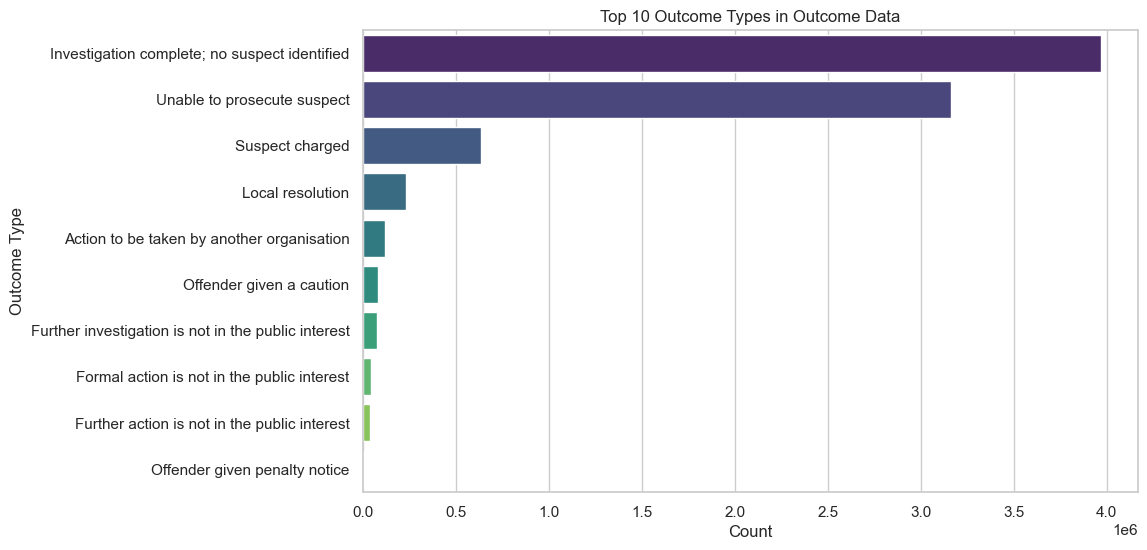

In [10]:
# Anand

# top 10 outcomes in outcome Data

top_outcomes = outcomes_df['Outcome type'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_outcomes.index, x=top_outcomes.values, palette='viridis')
plt.title('Top 10 Outcome Types in Outcome Data')
plt.xlabel('Count')
plt.ylabel('Outcome Type')
plt.show()

- In criminal cases that required further action / investigation, 90-95% of them are that no suspect of the crime could be identified or that the police force was unable to prosecute an indentified suspect.

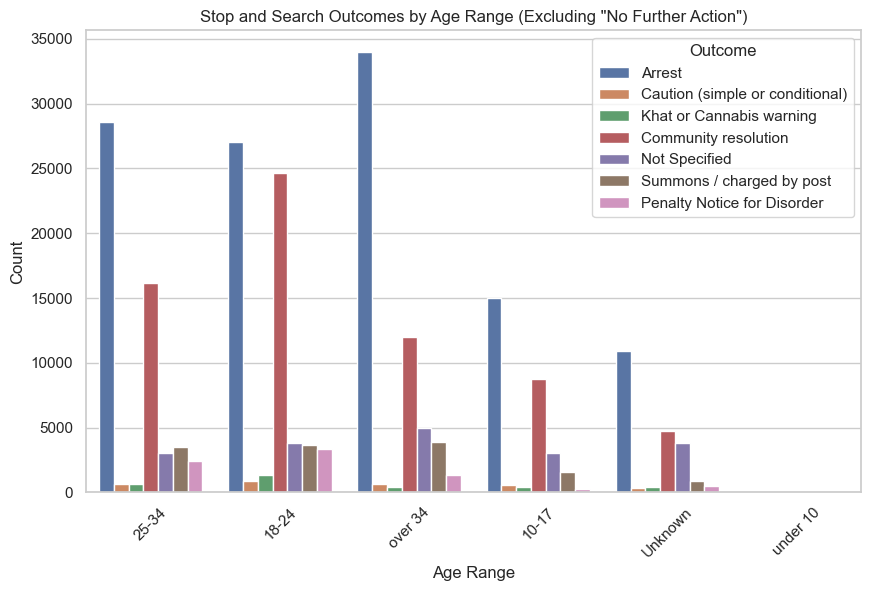

In [11]:
# Dylan

# don't use 'A no further action disposal' as it is a placeholder value
filtered_stop_and_search_df = stop_and_search_df[stop_and_search_df['Outcome'] != 'A no further action disposal']

# age range vs outcome in stop and search data
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_stop_and_search_df, x='Age range', hue='Outcome')
plt.title('Stop and Search Outcomes by Age Range (Excluding "No Further Action")')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.show()

In Stop and Search cases, all age ranges had the same relative ordering of outcomes being: 1) Arrest, 2) Community Resolution. It is particularly interesting to notice that even for children in the 10-17 age bucket that being arrested is the dominant outcome from a stop and search.

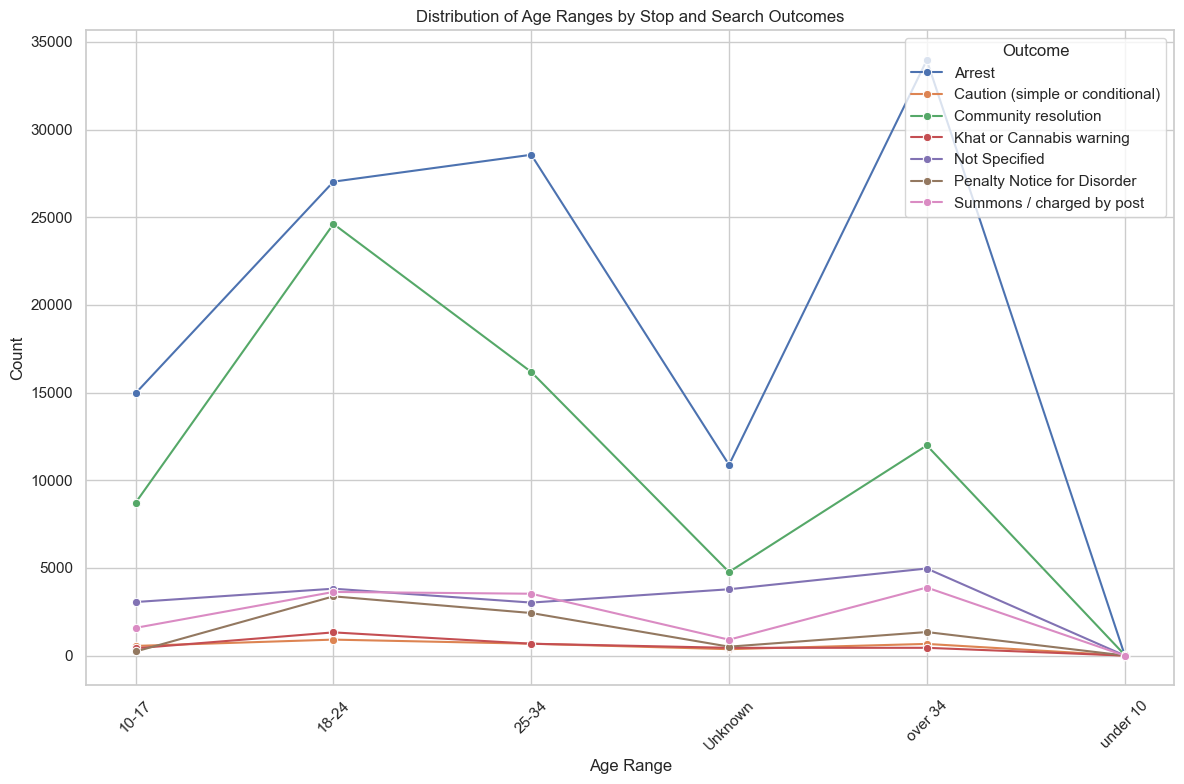

In [12]:
#Dylan
pivot_data = filtered_stop_and_search_df.groupby(['Age range', 'Outcome']).size().reset_index(name='Count')
#Provides a proper indexing method for the df

plt.figure(figsize=(12, 8))
sns.lineplot(data=pivot_data, x='Age range', y='Count', hue='Outcome', marker='o')
#Create a line plot for age range and crime category

plt.title('Distribution of Age Ranges by Stop and Search Outcomes')
plt.xlabel('Age Range')
plt.ylabel('Count')

plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.tight_layout()


# Add labels and title

plt.show()

With the help of this new plot, we can clearly see that the 25–34+ age groups have the highest count of arrests, indicating that this demographic is most frequently subject to stop-and-search leading to arrests. Also, the 18-24 age group contributed to the most cases of community resoultion. This fact makese sense, given that a government should aim to rehabilitate young people for their actions. This same age group also had the largest count for penalty notice of disorder, indicating a lack of awareness from young people.

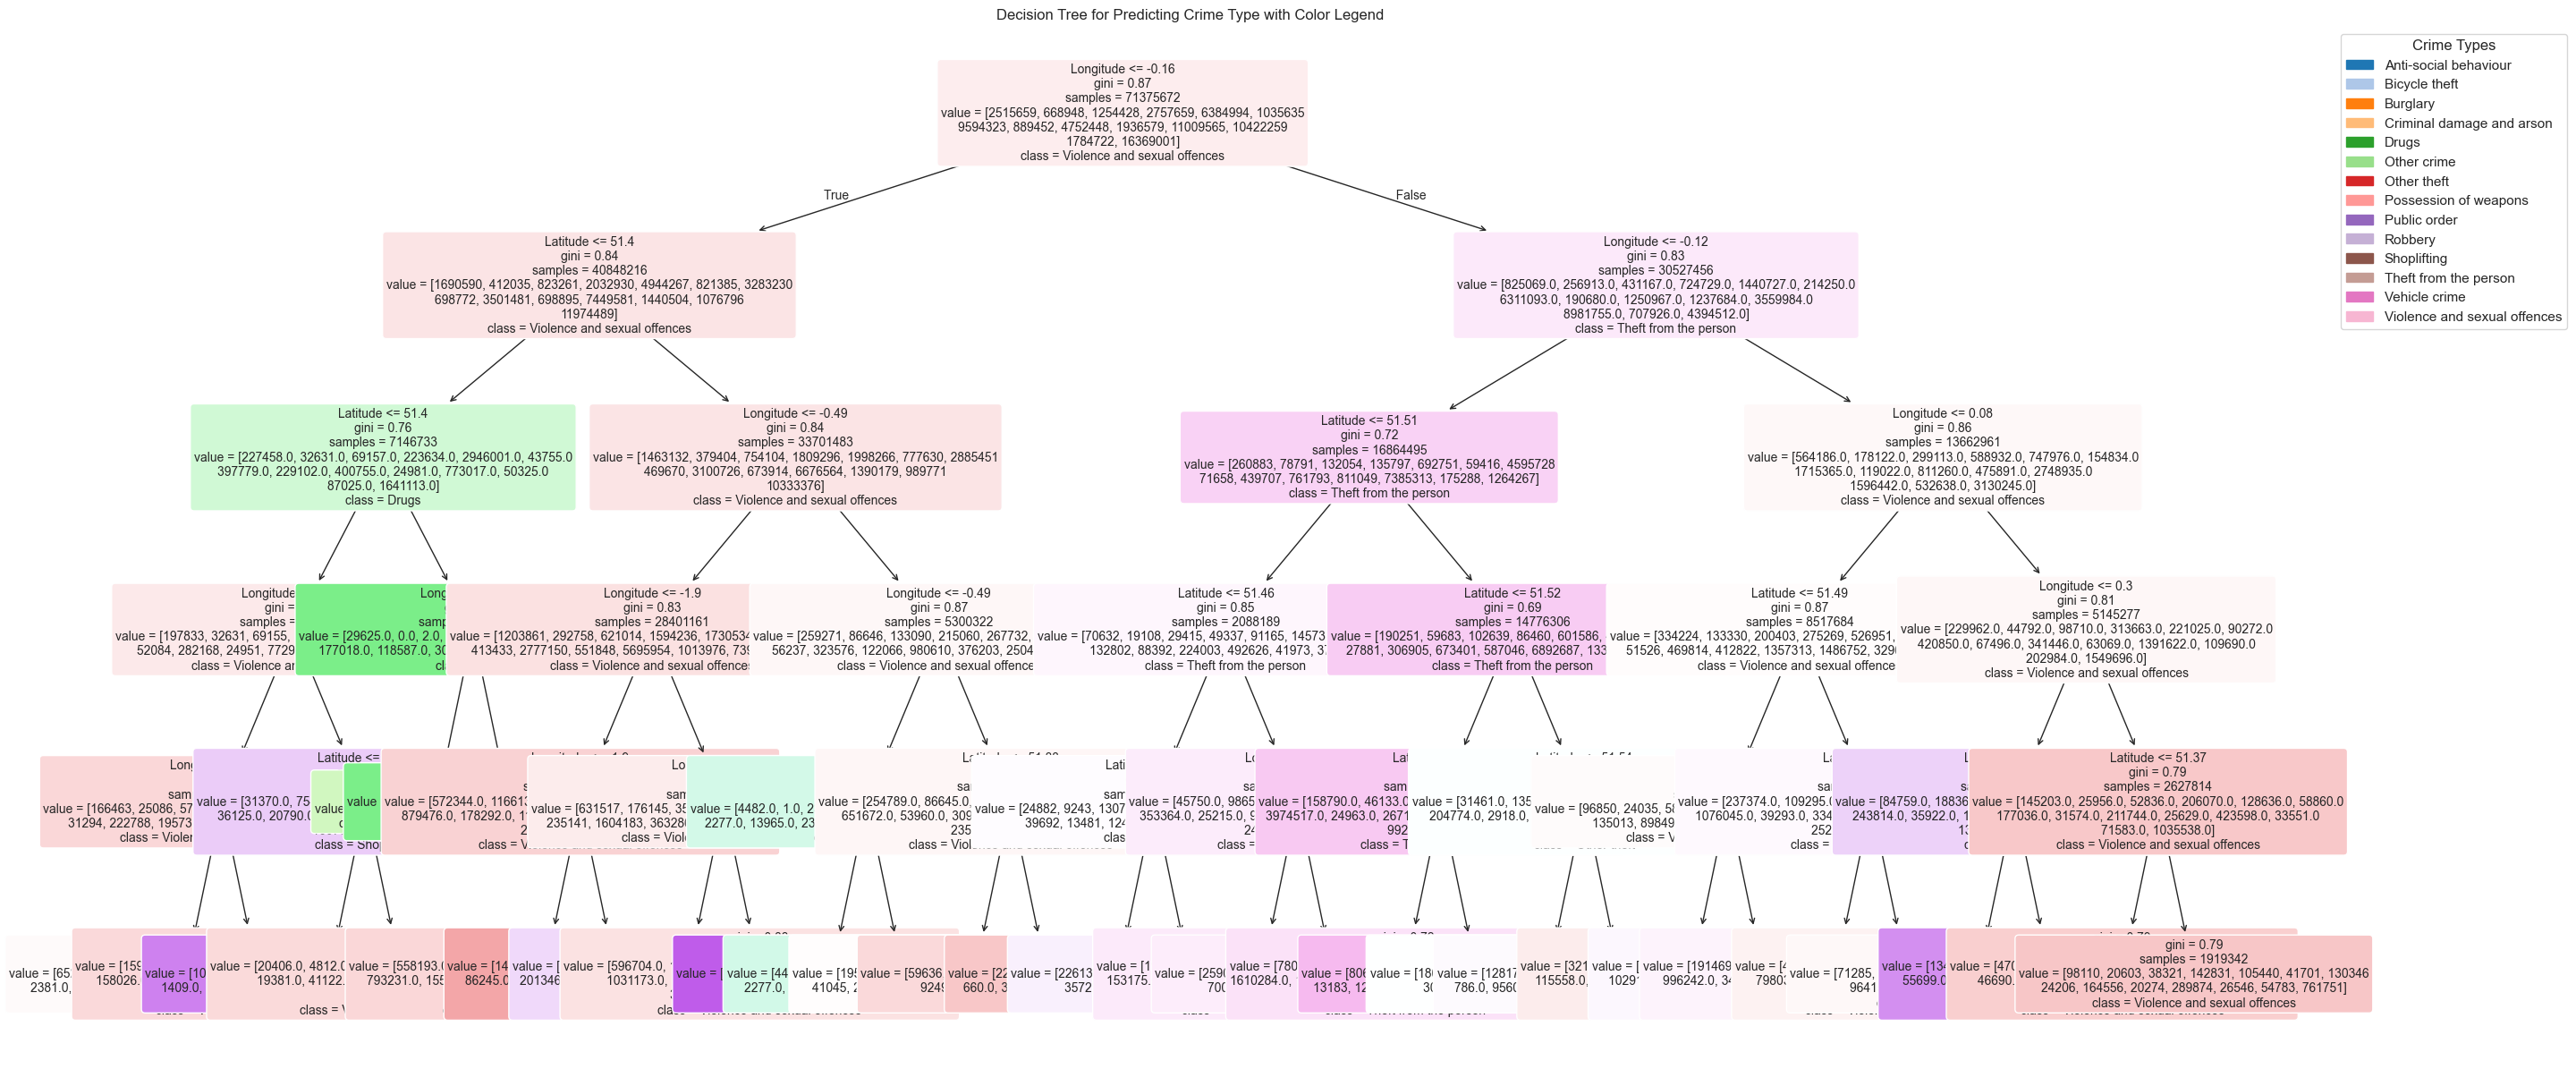

In [23]:
#Dylan



merged_data_cleaned['Latitude'] = merged_data_cleaned['ActualLocation'].apply(lambda x: float(x.split(',')[0].strip()))
merged_data_cleaned['Longitude'] = merged_data_cleaned['ActualLocation'].apply(lambda x: float(x.split(',')[1].strip()))

# Separates 'Actual Location' into 'Latitude' and 'Longitude'

crime_data = merged_data_cleaned[['Latitude', 'Longitude', 'Crime type']].dropna()
# Preparing the dataset with the new columns

le = LabelEncoder()
# Encodes the 'Crime type' data to numeric labels

crime_data['Crime type encoded'] = le.fit_transform(crime_data['Crime type'])

# Features and target variable
X = crime_data[['Latitude', 'Longitude']]  # using only geographic coordinates as features
y = crime_data['Crime type encoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Split the data into training and testing sets

dectree = DecisionTreeClassifier(max_depth=5, random_state=42)
dectree.fit(X_train, y_train)
# Train the decision tree with coordinate data


class_ref = le.classes_
coloring = [plt.cm.tab20.colors[i] for i in range(len(class_ref))]
# Generating a color map from the tree's classes

patches = [mpatches.Patch(color=coloring[i], label=class_names[i]) for i in range(len(class_ref))]
# Creating a patch (proxy artist) for each class for the legend




plt.figure(figsize=(30, 15))
tree_plot = plot_tree(dectree, filled=True, feature_names=['Latitude', 'Longitude'], class_names=class_names, rounded=True, proportion=False, precision=2, fontsize=10)
plt.title('Decision Tree for Predicting Crime Type with Color Legend')
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Crime Types")
plt.show()
# Plot the Meerged Crime decision tree

In [24]:
# Richard

# creating a new df with the city name, crime type, and latitude and longitude based off of the street_df and the LSOA name
stdf = street_df[['LSOA name', 'Crime type', 'Latitude', 'Longitude']]
# initialize the city column to be empty
stdf.loc[:, 'City'] = ''

# break the LSOA name into segments and grab everything except for the code connected at the very end
stdf['City'] = stdf['LSOA name'].apply(lambda x:' '.join(x.split()[:-1]))

# create a dictonary with the city and cords for the mapping based off of techniques in hw1 part 3
dictlocation = dict(zip(stdf['City'], zip(stdf['Longitude'], stdf['Latitude'])))

print('done')

done


In [25]:
# Richard

url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip"
world = gpd.read_file(url)
uk = world[world['NAME_EN'] == 'United Kingdom']

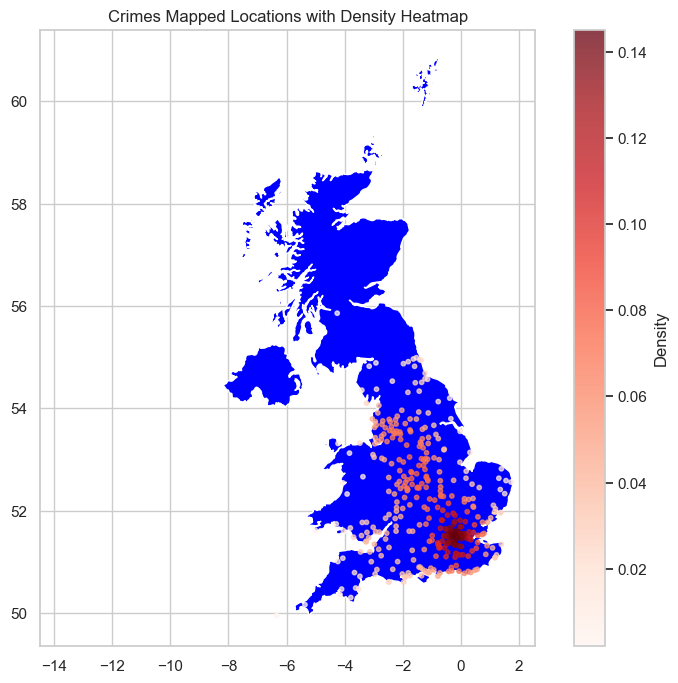

In [26]:
# Dylan / Richard

from scipy.stats import gaussian_kde
import numpy as np

lons = [lon for lon, lat in dictlocation.values()]
lats = [lat for lon, lat in dictlocation.values()]

# Establishes a proper KDE format (Kernel Density Estimation) 

xy = np.vstack([lons, lats])  # Combine longitude and latitude into a 2D array
kde = gaussian_kde(xy)  
# Calculate KDE for these locations
density = kde(xy)  
#Calculate density for distributions

fig, ax = plt.subplots(figsize=(10, 8))
uk.plot(ax=ax, color='blue', edgecolor='white')  # Plot the UK map
# Create the plot for the uk map

sc = ax.scatter(lons, lats, c=density, cmap='Reds', s=10, alpha=0.75)  
plt.colorbar(sc, ax=ax, label='Density')  # Add a color bar to indicate density values
# Scatter plot using crime density color

plt.title('Crimes Mapped Locations with Density Heatmap')
plt.show()

# Classification

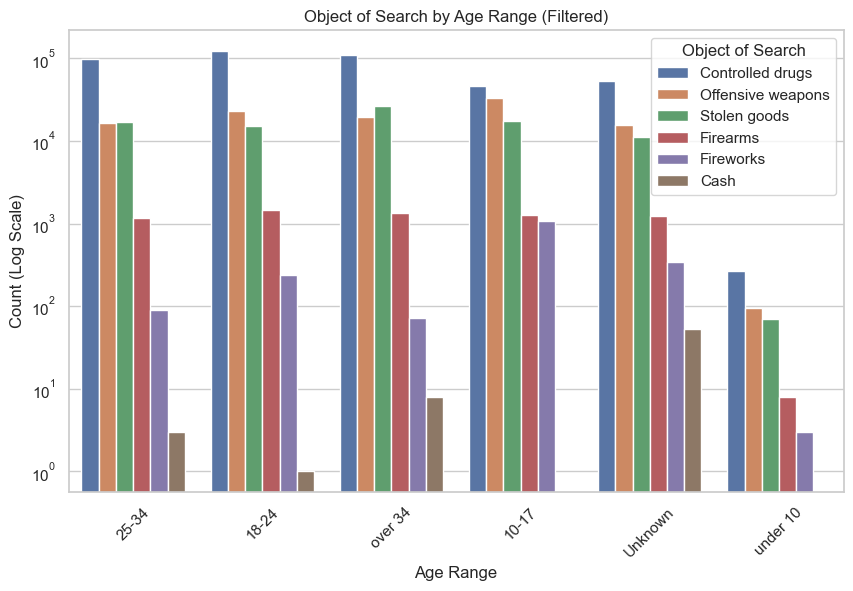

In [27]:
# Anand

desired_objects = ["Controlled drugs", "Offensive weapons", "Stolen goods", "Fireworks", "Firearms", "Cash"]
filtered_data = stop_and_search_df[stop_and_search_df['Object of search'].isin(desired_objects)]

# age range vs object of search 
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_data, x='Age range', hue='Object of search')
plt.yscale('log') 
plt.title('Object of Search by Age Range (Filtered)')
plt.xlabel('Age Range')
plt.ylabel('Count (Log Scale)')
plt.xticks(rotation=45)
plt.legend(title='Object of Search')
plt.show()

In [28]:
# Anand

#select attributes and remove missing values
model_df = stop_and_search_df[['Age range', 'Object of search']].dropna()
model_df = model_df[(model_df['Age range'] != 'Unknown') & (model_df['Object of search'] != 'Unknown')]

In [29]:
# Anand

from sklearn.preprocessing import LabelEncoder

label_encoder_age = LabelEncoder()
label_encoder_object = LabelEncoder()

model_df['Age range'] = label_encoder_age.fit_transform(model_df['Age range'])
model_df['Object of search'] = label_encoder_object.fit_transform(model_df['Object of search'])

In [30]:
# Anand

from sklearn.model_selection import train_test_split

X = model_df[['Age range']]
y = model_df['Object of search']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

In [31]:
# Anand

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# parameters found to be optimal with given data
rf_model = RandomForestClassifier(
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    random_state=36
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Accuracy on Test Data:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy on Test Data: 0.6037883694339834
